In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define the custom pastel violet palette ---
PASTEL_VIOLET = ['#b39ddb', '#7e57c2', '#d1c4e9', '#9575cd', '#ede7f6']

parquet_file_path = '../data/electricity/processed/demanddata_combined.parquet'

print(f"Loading data from: {parquet_file_path}")

try:
    # 2. Set display option to show ALL columns
    pd.set_option('display.max_columns', None)
    
    # 3. Read the Parquet file
    df = pd.read_parquet(parquet_file_path)
    
    print("✅ Successfully loaded Parquet file.")
    print("--- Displaying First 5 Rows (Complete) ---")
    
    # 4. Display the first 5 rows
    # In a notebook, 'display()' gives a nicer table output
    display(df.head(5))

except FileNotFoundError:
    print(f"❌ Error: Could not find the file.")
    print(f"Please check this path: {parquet_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Loading data from: ../data/electricity/processed/demanddata_combined.parquet
✅ Successfully loaded Parquet file.
--- Displaying First 5 Rows (Complete) ---


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,SCOTTISH_TRANSFER,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,2001-01-01,1,38631,NaN,34060.0,NaN,NaN,NaN,NaN,0,862,NaN,1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001-01-01,2,39808,NaN,35370.0,NaN,NaN,NaN,NaN,0,153,NaN,1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001-01-01,3,40039,NaN,35680.0,NaN,NaN,NaN,NaN,0,18,NaN,1511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001-01-01,4,39339,NaN,35029.0,NaN,NaN,NaN,NaN,0,9,NaN,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001-01-01,5,38295,NaN,34047.0,NaN,NaN,NaN,NaN,0,211,NaN,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# --- Cleaning Step 1: Feature Engineering the Date ---

# Create a new column for the year of sale
df['Year'] = df['SETTLEMENT_DATE'].dt.year

# Convert the new year column to a memory-efficient integer type
# Assuming we don't need any special features beyond the integer year
df['Year'] = df['Year'].astype('int16')
print("Created 'Year' column:")
print(df[['SETTLEMENT_DATE', 'Year']].head())

Created 'Year' column:
  SETTLEMENT_DATE  Year
0      2001-01-01  2001
1      2001-01-01  2001
2      2001-01-01  2001
3      2001-01-01  2001
4      2001-01-01  2001


In [4]:
# --- Cleaning Step 4: Check for Missing Values (Na-values) ---

print("\nMissing Value Check (Initial):")
print(df.isnull().sum())
print("-" * 30)


Missing Value Check (Initial):
SETTLEMENT_DATE                   0
SETTLEMENT_PERIOD                 0
ND                                0
TSD                           70128
ENGLAND_WALES_DEMAND              0
EMBEDDED_WIND_GENERATION     105168
EMBEDDED_WIND_CAPACITY       105168
EMBEDDED_SOLAR_GENERATION    140256
EMBEDDED_SOLAR_CAPACITY      140256
NON_BM_STOR                       0
PUMP_STORAGE_PUMPING              0
SCOTTISH_TRANSFER            385680
IFA_FLOW                          0
IFA2_FLOW                    140256
BRITNED_FLOW                 140256
MOYLE_FLOW                    70128
EAST_WEST_FLOW               140256
NEMO_FLOW                    140256
NSL_FLOW                     315552
ELECLINK_FLOW                315552
VIKING_FLOW                  315552
GREENLINK_FLOW               315552
Year                              0
dtype: int64
------------------------------


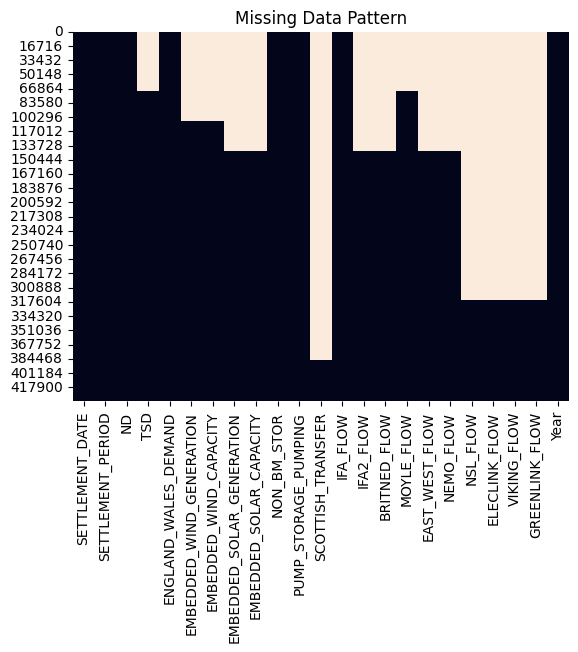

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

In [5]:
df['TSD'].fillna(0, inplace=True)
df['EMBEDDED_WIND_GENERATION'].fillna(0, inplace=True)
df['EMBEDDED_WIND_CAPACITY'].fillna(0, inplace=True)
df['EMBEDDED_SOLAR_GENERATION'].fillna(0, inplace=True)
df['EMBEDDED_SOLAR_CAPACITY'].fillna(0, inplace=True)
df['SCOTTISH_TRANSFER'].fillna(0, inplace=True)
df['IFA2_FLOW'].fillna(0, inplace=True)
df['BRITNED_FLOW'].fillna(0, inplace=True)
df['MOYLE_FLOW'].fillna(0, inplace=True)
df['EAST_WEST_FLOW'].fillna(0, inplace=True)
df['NEMO_FLOW'].fillna(0, inplace=True)
df['NSL_FLOW'].fillna(0, inplace=True)
df['ELECLINK_FLOW'].fillna(0, inplace=True)
df['VIKING_FLOW'].fillna(0, inplace=True)
df['GREENLINK_FLOW'].fillna(0, inplace=True)



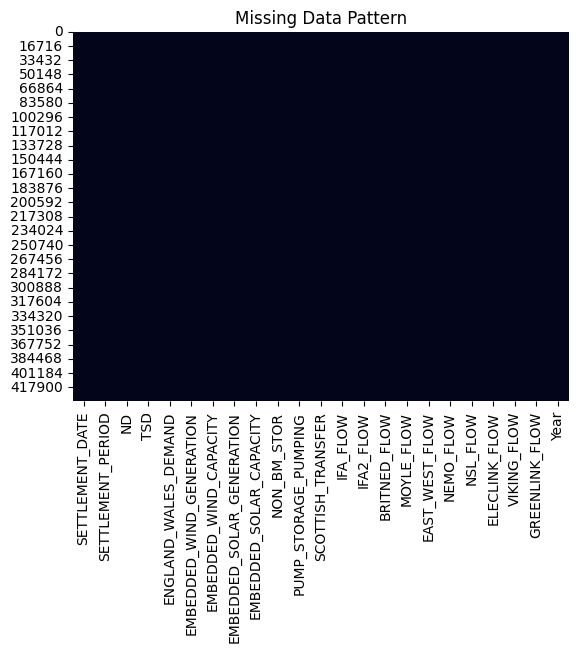

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Pattern")
plt.show()

1
2
3


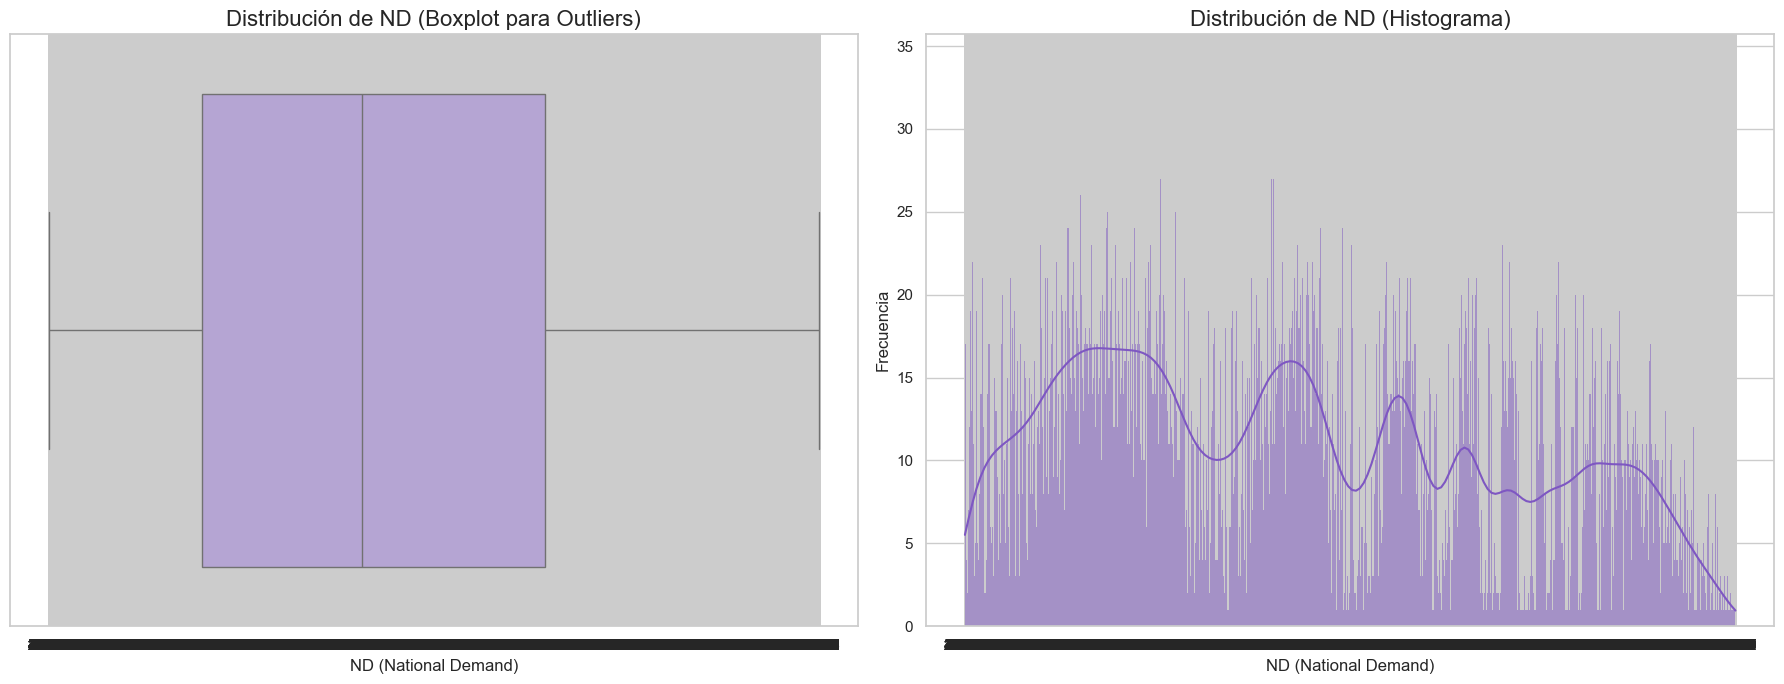

In [7]:
# --- Visualización de Outliers para 'ND' ---

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(18, 7))

print(1)

# --- Gráfico 1: Boxplot (Diagrama de Caja) ---
# Ideal para identificar la mediana, los cuartiles y los outliers
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1er gráfico
sns.boxplot(x=df['ND'], color=PASTEL_VIOLET[0])
plt.title('Distribución de ND (Boxplot para Outliers)', fontsize=16)
plt.xlabel('ND (National Demand)', fontsize=12)

print(2)

# --- Gráfico 2: Histograma (Distribución) ---
# Muestra la frecuencia y forma de la distribución
plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2do gráfico
sns.histplot(df['ND'], kde=True, bins=50, color=PASTEL_VIOLET[1])
plt.title('Distribución de ND (Histograma)', fontsize=16)
plt.xlabel('ND (National Demand)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

print(3)

# Mostrar los gráficos
plt.tight_layout() # Ajusta los gráficos para que no se solapen
plt.show()

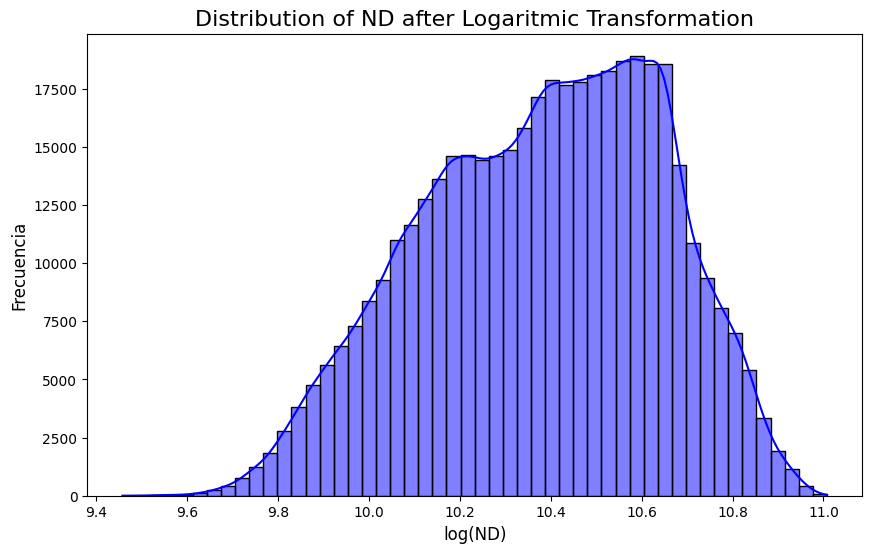

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- LA CORRECCIÓN ESTÁ AQUÍ ---

# 1. Convierte la columna 'ND' a tipo numérico.
#    errors='coerce' es importante: convertirá cualquier valor
#    que no sea un número (ej. texto vacío) en NaN (Not a Number).
df['ND'] = pd.to_numeric(df['ND'], errors='coerce')

# 2. Ahora que 'ND' es numérico, aplica la transformación logarítmica.
#    Se suma 1 para evitar el error de log(0).
df['ND_log'] = np.log(df['ND'] + 1)

# --- Graficar la nueva distribución transformada ---
plt.figure(figsize=(10, 6))
sns.histplot(df['ND_log'], kde=True, bins=50, color='blue')
plt.title('Distribution of ND after Logaritmic Transformation', fontsize=16)
plt.xlabel('log(ND)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

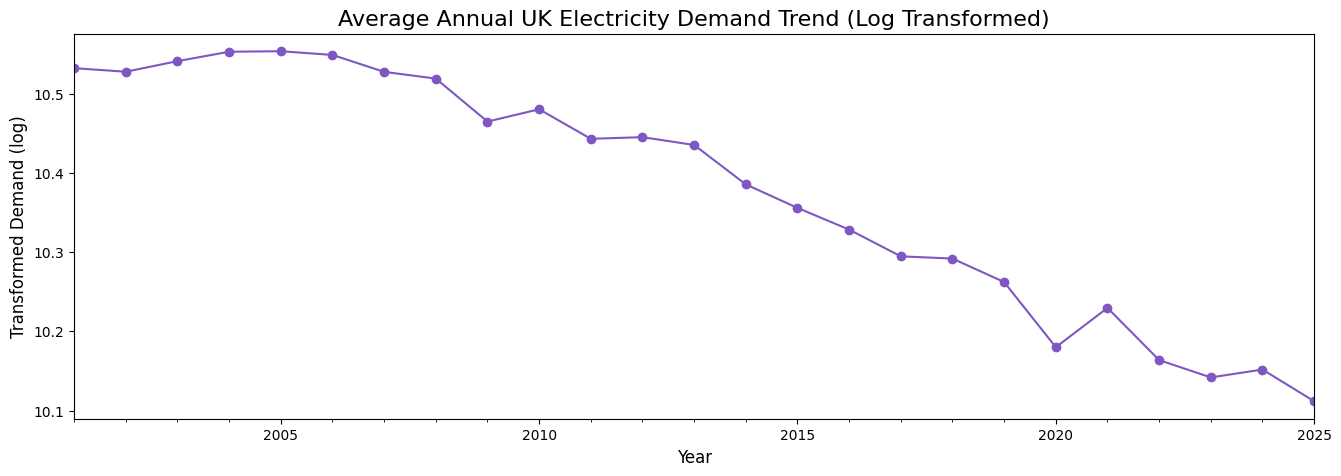

/var/folders/6z/vs2gqd6s6zx7b6vqyq8nbwrh0000gn/T/ipykernel_1164/2705446528.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=target_col, data=df, palette=PASTEL_VIOLET) # Ahora 'month' existe
/var/folders/6z/vs2gqd6s6zx7b6vqyq8nbwrh0000gn/T/ipykernel_1164/2705446528.py:35: UserWarning: 
The palette list has fewer values (5) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='month', y=target_col, data=df, palette=PASTEL_VIOLET) # Ahora 'month' existe


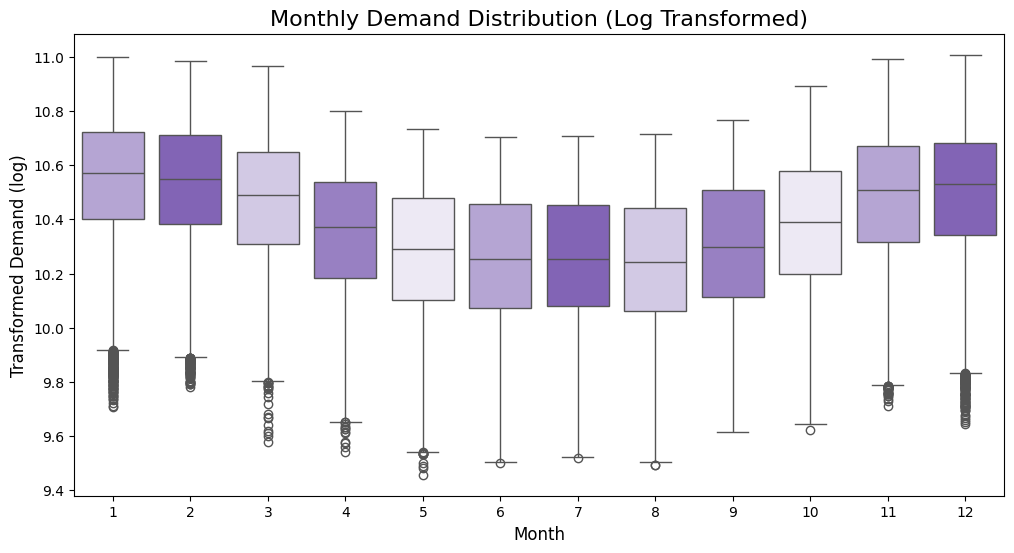

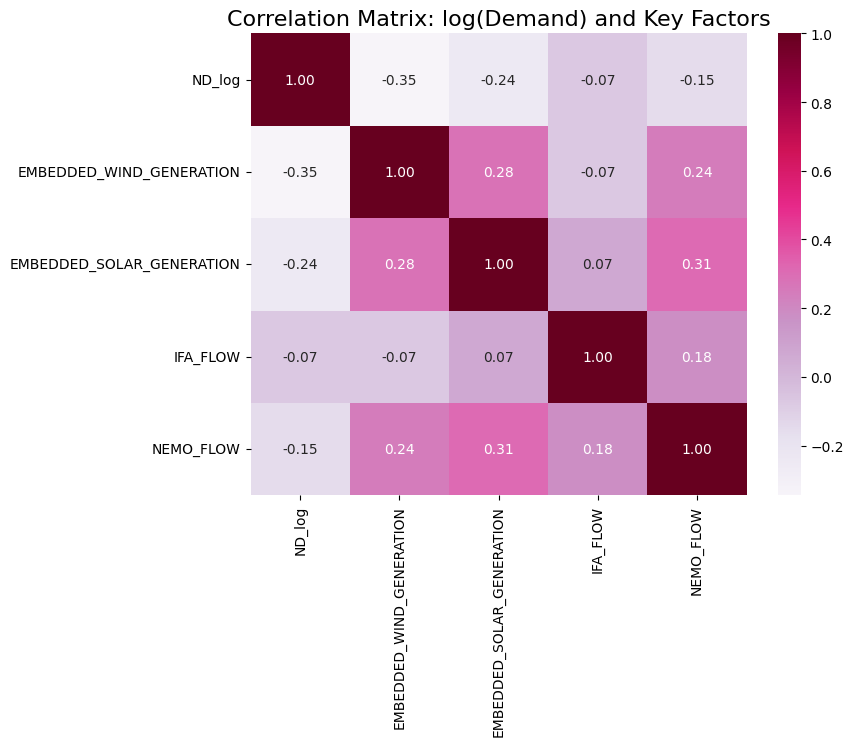


--- EDA Complete ---
Final DataFrame Shape: (434590, 26)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. ASEGURARSE DE QUE EL ÍNDICE Y LAS COLUMNAS DE TIEMPO EXISTEN ---

# Asegúrate de que el índice sigue siendo un DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'], errors='coerce')
    df = df.set_index('SETTLEMENT_DATE')

# Crea las columnas de tiempo necesarias para los gráficos, extrayéndolas del índice
df['month'] = df.index.month
df['hour'] = df.index.hour
df['day_name'] = df.index.day_name()
# ----------------------------------

# --- 2. CÓDIGO DE VISUALIZACIÓN (YA CORREGIDO) ---

target_col = 'ND_log' 

# --- 7. Long-Term Trend (Annual Resampling) ---
# print("Generando Gráfico 7: Tendencia Anual...")  <-- Eliminado
plt.figure(figsize=(16, 5))
df[target_col].resample('Y').mean().plot(marker='o', linestyle='-', color=PASTEL_VIOLET[1])
plt.title('Average Annual UK Electricity Demand Trend (Log Transformed)', fontsize=16)
plt.ylabel('Transformed Demand (log)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show();

# --- 8. Annual Seasonality (Monthly Boxplot) ---
# print("Generando Gráfico 8: Estacionalidad Mensual (Boxplot)...")  <-- Eliminado
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y=target_col, data=df, palette=PASTEL_VIOLET) # Ahora 'month' existe
plt.title('Monthly Demand Distribution (Log Transformed)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Transformed Demand (log)', fontsize=12)
plt.show();

# --- 10. Feature Correlation (Renewables) ---
# print("Generando Gráfico 10: Matriz de Correlación...")  <-- Eliminado

# Los nombres de las columnas estaban en minúsculas pero en tu DataFrame están en MAYÚSCULAS.
correlation_cols = [
    target_col, 
    'EMBEDDED_WIND_GENERATION', 
    'EMBEDDED_SOLAR_GENERATION', 
    'IFA_FLOW', 
    'NEMO_FLOW'
]

plt.figure(figsize=(8, 6))
sns.heatmap(df[correlation_cols].corr(), annot=True, cmap='PuRd', fmt=".2f")
plt.title('Correlation Matrix: log(Demand) and Key Factors', fontsize=16)
plt.show();

# Final check
print("\n--- EDA Complete ---")
print(f"Final DataFrame Shape: {df.shape}")